In [1]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from pysankey2 import Sankey
import matplotlib as mpl
from pathlib import Path
import os.path as op
import pandas as pd
import numpy as np
import json
import os

In [2]:
import pyarrow as pa
import pyarrow.parquet as pq

In [3]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import adjusted_mutual_info_score, adjusted_rand_score

In [4]:
from cluster import reindex_clusters

In [5]:
# Join similarity matrices
# sim_paths = Path('../data/similarity/')

# df_similarity = None
# for f in sim_paths.rglob('*h5'):
#     dataset, atlas = str(f).split('/')[-1].split('_')[0:2]
#     tdf = pd.read_hdf(f)
#     tdf['dataset'], tdf['atlas'] = dataset, atlas
    
#     if df_similarity is None:
#         df_similarity = tdf
#     else:
#         df_similarity = pd.concat([df_similarity, tdf])

# pd.to_pickle(df_similarity, '../data/clustering/preprocessed_similarity.pkl')

In [75]:
df_cluster_def = pd.read_pickle('../data/clustering/cluster_definitions.pkl')
df_cluster_dat = pd.read_pickle('../data/clustering/cluster_membership.pkl')
df_similarity = pd.read_pickle('../data/clustering/preprocessed_similarity.pkl')

dataset = 'SWU1'
df_cluster_def = df_cluster_def[df_cluster_def['dataset'] == dataset]
df_cluster_dat = df_cluster_dat[df_cluster_dat['dataset'] == dataset]
df_similarity = df_similarity[df_similarity['dataset'] == dataset]


da = ['dataset', 'atlas']
combos = df_cluster_def.value_counts(da).index
sliced_da = lambda df, ds, at: df[(df['dataset'] == ds) & (df['atlas'] == at)]

In [76]:
cluster_orders = {}

get_signatures = lambda df, c: [np.reshape(_, -1) for _ in sliced_da(df, *c)['signature']]

c1 = combos[0]
s1 = get_signatures(df_cluster_def, c1)
nc1 = len(s1)

cluster_orders[c1[1]] = np.arange(nc1)

In [77]:
df_cluster_def

,label,members,signature,dataset,atlas
0,0,"[2, 4, 5, 7, 10, 11, 12, 13, 18, 20, 21, 23, 2...","[[0.94873046875, 0.93109130859375, 0.799438476...",SWU1,cc2
1,1,"[0, 3, 6, 8, 9, 15, 17, 19, 22, 24, 28, 29, 31...","[[0.9366629464285714, 0.9235491071428571, 0.82...",SWU1,cc2
2,2,"[1, 14, 16]","[[0.974609375, 0.9069010416666666, 0.813151041...",SWU1,cc2
3,3,"[33, 36, 38]","[[0.9811197916666666, 0.9010416666666666, 0.75...",SWU1,cc2
0,0,"[1, 2, 3, 4, 6, 8, 14, 15, 16, 21, 24, 25, 27,...","[[0.9588448660714286, 0.9351283482142857, 0.80...",SWU1,des
1,1,"[0, 7, 9, 17, 18, 19, 22, 26, 29, 30, 34, 35, ...","[[0.9524356617647058, 0.9341681985294118, 0.81...",SWU1,des
2,2,"[5, 10, 11, 12, 13, 20, 23, 45, 48, 49, 51, 54...","[[0.9535435267857143, 0.9388950892857143, 0.74...",SWU1,des
0,0,"[5, 7, 10, 11, 12, 13, 18, 20, 21, 23, 25, 30,...","[[0.9575892857142857, 0.9391741071428571, 0.75...",SWU1,hox
1,1,"[0, 2, 9, 17, 19, 22, 24, 26, 28, 29, 31, 32, ...","[[0.95087890625, 0.93193359375, 0.790625, 0.77...",SWU1,hox
2,2,"[3, 4, 6, 8, 15, 16, 27, 42, 43, 44, 45, 53, 5...","[[0.9637451171875, 0.94140625, 0.829345703125,...",SWU1,hox


In [78]:
for idx, c2 in enumerate(combos[1:]):
    s2 = get_signatures(df_cluster_def, c2)
    nc2 = len(s2)
    ts = np.stack(s1 + s2)
    
    ts_sim = np.corrcoef(ts)
    mval = np.min(ts_sim)

    ts_sim[0:nc1, 0:nc1] = mval
    ts_sim[nc1:nc1+nc2, nc1:nc1+nc2] = mval

    locs = []

    for _ in range(min([nc1, nc2])):
        l = np.argmax(ts_sim[_, :])
        ts_sim[l,:] = mval
        ts_sim[:,l] = mval
        ts_sim[_,l] = 1
        ts_sim[l,_] = 1
        locs += [l - nc1]

    cluster_orders[c2[1]] = np.argsort(locs)

cluster_orders

{'aal': array([0, 1, 2, 3, 4]),
 'cc2': array([0, 2, 1, 3]),
 'hox': array([3, 2, 0, 1]),
 'des': array([1, 2, 0])}

In [79]:
cois = ['subject', 'session', 'dataset']

df_clust = df_similarity[cois].groupby(['subject', 'session']).max()

for idx, row in df_cluster_dat.iterrows():
    k = tuple(row[['dataset', 'atlas']])
    v = row['labels']
    df_clust[k[1]] = reindex_clusters(v, order=cluster_orders[k[1]])

df_clust

dataset  cc2  des  hox  aal
subject session                            
0027203 1          SWU1    2    2    2    2
        2          SWU1    1    1    1    1
        3          SWU1    0    1    2    0
0027204 1          SWU1    2    1    0    3
        2          SWU1    0    1    0    0
        3          SWU1    0    0    3    0
0027205 1          SWU1    2    1    0    0
        2          SWU1    0    2    3    0
        3          SWU1    2    1    0    0
0027206 1          SWU1    2    2    2    0
        2          SWU1    0    0    3    0
        3          SWU1    0    0    3    0
0027207 1          SWU1    0    0    3    1
        2          SWU1    0    0    3    0
        3          SWU1    1    1    1    4
0027208 1          SWU1    2    1    0    3
        2          SWU1    1    1    0    4
        3          SWU1    2    2    2    2
0027209 1          SWU1    0    2    3    1
        3          SWU1    2    2    2    1
0027210 1          SWU1    0    0    3    1
        2          SWU1    0    1    3    1
        3          SWU1    2    2    2    2
0027211 1          SWU1    0    0    3    0
        2          SWU1    2    1    2    0
        3          SWU1    0    1    3    0
0027212 1          SWU1    0    2    2    2
        2          SWU1    0    1    0    0
        3          SWU1    2    1    2    0
0027213 1          SWU1    2    2    2    3
        2          SWU1    0    2    3    1
        3          SWU1    2    1    2    1
0027214 1          SWU1    2    1    2    0
        2          SWU1    3    1    2    3
        3          SWU1    2    2    2    2
0027215 1          SWU1    2    2    2    0
        2          SWU1    3    2    2    3
        3          SWU1    0    1    3    2
0027216 1          SWU1    3    1    3    3
        2          SWU1    0    2    3    2
        3          SWU1    2    2    2    2
0027217 1          SWU1    0    1    3    3
        2          SWU1    0    1    0    1
        3          SWU1    0    1    0    3
0027218 1          SWU1    0    1    0    0
        2          SWU1    2    0    0    1
        3          SWU1    2    2    2    2
0027219 1          SWU1    0    2    3    0
        2          SWU1    0    0    3    0
        3          SWU1    0    0    3    1
0027220 1          SWU1    0    1    2    0
        2          SWU1    0    0    3    0
        3          SWU1    2    1    2    2
0027221 1          SWU1    0    1    0    0
        2          SWU1    0    0    0    0
        3          SWU1    0    0    0    0
0027222 1          SWU1    0    0    3    0
        2          SWU1    2    1    0    2
        3          SWU1    0    1    0    0

In [80]:
nc = np.max([len(_) for _ in cluster_orders.values()])

In [81]:
cm = mpl.cm.get_cmap('Dark2').colors

atlas = 'BNU1'
order = ['aal', 'cc2', 'hox', 'des']
col_names = {p: 'layer'+str(_+1) for _, p in enumerate(order)}
cords = {'layer'+str(_+1): np.arange(len(cluster_orders[p])) for _, p in enumerate(order)}

dfc2 = df_clust[order]
dfc2 = dfc2.rename(columns=col_names)
dfc2 = dfc2.reset_index().drop(columns=['subject', 'session'])

nc = np.max([len(_) for _ in cluster_orders.values()])
color_dict = {_: cm[_] for _ in range(nc)}

# cords = {"layer{0}".format(_+1): list(range(len(v)))
        #  for _, (k, v) in enumerate(cluster_orders.items())}

# dfc2, cords

(<Figure size 1080x1080 with 1 Axes>, <AxesSubplot:>)

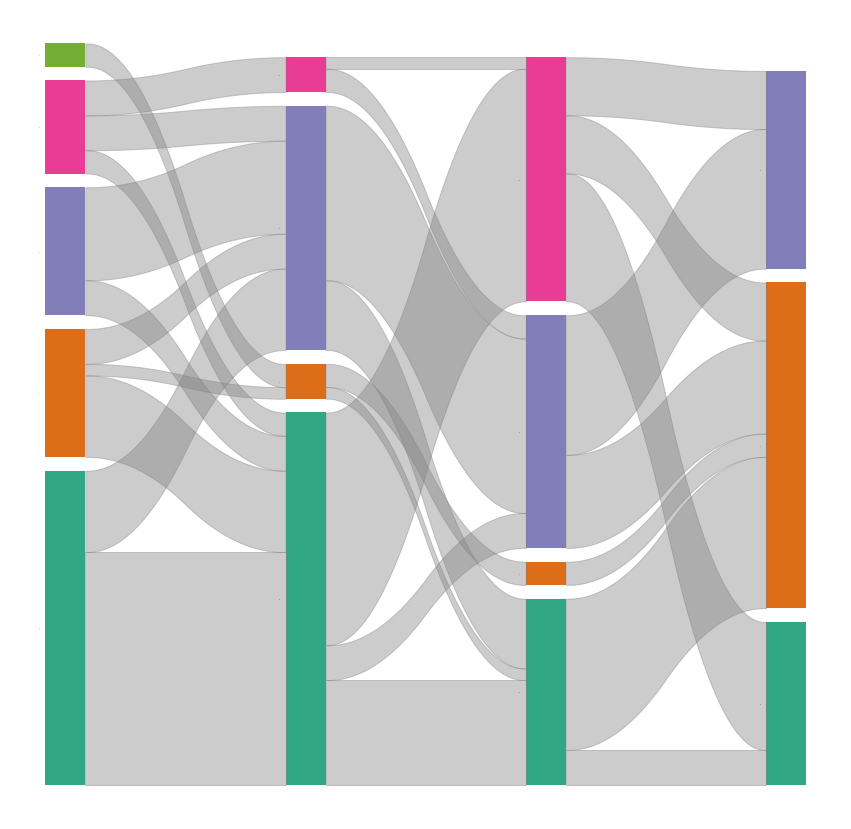

In [82]:
subject_clustering = Sankey(dfc2, colorMode='global', stripColor='gray',
                            colorDict= color_dict, layerLabels=cords)

subject_clustering.plot(figSize=(15, 15), fontSize=0)

In [83]:
df_cluster_dat

,dataset,atlas,labels
59,SWU1,cc2,"[1, 2, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 2, ..."
60,SWU1,des,"[1, 0, 0, 0, 0, 2, 0, 1, 0, 1, 2, 2, 2, 2, 0, ..."
61,SWU1,hox,"[1, 3, 1, 2, 2, 0, 2, 0, 2, 1, 0, 0, 0, 0, 3, ..."
62,SWU1,aal,"[2, 1, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 4, ..."


In [84]:
tdf = []
for idx, c1 in enumerate(combos):
    for jdx, c2 in enumerate(combos[idx+1:]):
        l1 = sliced_da(df_cluster_dat, *c1).labels.values[0]
        l2 = sliced_da(df_cluster_dat, *c2).labels.values[0]
        tmp = l1 == l2
        
        tdf += [{
            "dataset": c1[0],
            "atlas1": c1[1],
            "atlas2": c2[1],
            "ARI": adjusted_rand_score(l1, l2),
            "AMI": adjusted_mutual_info_score(l1, l2),
            "Percent Overlap": np.sum(tmp)/len(tmp)*100
        }]

df_cluster_overlaps = pd.DataFrame.from_dict(tdf)
df_cluster_overlaps

,dataset,atlas1,atlas2,ARI,AMI,Percent Overlap
0,SWU1,aal,cc2,0.176521,0.200721,44.067797
1,SWU1,aal,hox,0.044331,0.058790,23.728814
2,SWU1,aal,des,0.050072,0.112936,27.118644
3,SWU1,cc2,hox,0.335745,0.362042,61.016949
4,SWU1,cc2,des,0.032553,0.093051,38.983051
5,SWU1,hox,des,0.176297,0.255487,33.898305
